In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import statistics
from scipy.stats import gaussian_kde
from matplotlib import rcParams as rc

# generate toy data for TOV
def gen_TOV_samples(mean, std_dev, n_samples):
    samples = np.random.normal(loc=mean, scale=std_dev, size=n_samples)
    return samples

# use Monte carlo methods to compute the new masses with rotation
def gen_ROT_samples(TOV_samples,R_mean,R_error):
    mR_samples = []
    for i in range(len(TOV_samples)):
        mR_samples.append(TOV_samples[i]*np.random.normal(loc=R_mean,scale=R_error,size=1)[0])
    return mR_samples

# calculates a random integer from 0 to N
def random_int(upper_limit):
    return random.randint(0,upper_limit)

# Computes the probability of that the observed measurement is described by the theoretical value
# using Monte carlo sampling
def MC_prob(the_samples, exp_samples, nruns):
    # Monte Carlo code to compute probability
    count = 0
    diff_array = []
    for i in range(nruns):
        rTh = random_int(len(the_samples)-1)
        rEx = random_int(len(exp_samples)-1)
        mTh = the_samples[rTh]
        mEx = exp_samples[rEx]
        diff = mTh-mEx
        diff_array.append(diff)
        if (diff>0):
            count = count + 1

    prob = count/nruns
    return prob, diff_array

# Using the probability function, obtain a sampling array of the experimental measurement from LIGO
# uses accept/reject sampling
def gen_exp_samples(file,npoints):
    prob_func = np.loadtxt(file)
    size = len(prob_func)

    exp_masses = []
    for i in range(npoints):
        index = random_int(size-1)
        r = random.random()
        p = prob_func[index][1]
        mass = prob_func[index][0]
        if (r<p):
            exp_masses.append(mass)
    return exp_masses

def gen_KDE(samples, npoints, smooth_factor):
    kde = gaussian_kde(samples,bw_method=smooth_factor)
    x = np.linspace(0.95*min(samples),1.05*max(samples),npoints)
    kde_values = kde(x)
    return x, kde_values

In [5]:
# define the mass increase factors with rotation
rot_factor = 1.260
rot_error = 0.04

# import TOV masses
mTOV_samples = np.loadtxt("MCMC_complete_28.txt")[:,18]
#mTOV_samples = gen_TOV_samples(2.67,0.03,10000)

# generate maximum masses with rotation
mMAX_samples = gen_ROT_samples(mTOV_samples,rot_factor,rot_error)

# generate EXP masses
mEXP_samples = gen_exp_samples("mass_hs_data.txt",1000000)

# compute probability
prob, diff = MC_prob(mMAX_samples,mEXP_samples,100000)
print(prob)

0.33017


2.679555875 +- 0.026774893888653412
3.377216195824985 +- 0.11335246448588529
-0.20545385123406876


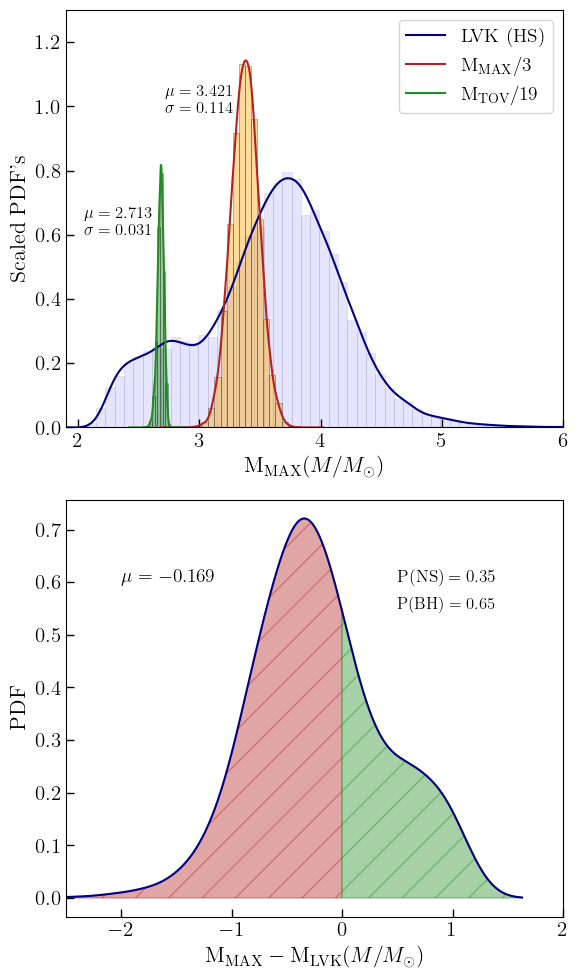

In [6]:
mean_TOV = statistics.mean(mTOV_samples)
mean_MAX = statistics.mean(mMAX_samples)
std_TOV = statistics.stdev(mTOV_samples)
std_MAX = statistics.stdev(mMAX_samples)
print(mean_TOV,"+-",std_TOV)
print(mean_MAX,"+-",std_MAX)

mean_diff = statistics.mean(diff)
print(mean_diff)

# Set font to a more professional style
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 16,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 14,
    'text.latex.preamble': r'\usepackage{bm}',
})

# Data for plotting
exp_data = np.loadtxt("mass_hs_data.txt")
xmax, ymax = gen_KDE(mMAX_samples,1000,0.2)
xtov, ytov = gen_KDE(mTOV_samples,2000,0.2)
prob, diff = MC_prob(mMAX_samples,mEXP_samples,100000)
xdiff, ydiff = gen_KDE(diff,1000,0.2)

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

# Customization for ax1
ax1.plot(exp_data[:,0], exp_data[:,1], label='LVK (HS)', color='navy',lw=1.5)
ax1.plot(xmax, ymax/3, label=r'$\mathrm{M_{MAX}/3}$', color='firebrick',lw=1.5)
ax1.plot(xtov, ytov/19, label=r'$\mathrm{M_{TOV}/19}$', color='forestgreen',lw=1.5)

ax1.hist(mEXP_samples,bins=60,density=True,edgecolor='black',lw=0.5,color='blue',alpha=0.1)
counts, bins, patches = ax1.hist(mTOV_samples,bins=10,density=True,edgecolor='black',lw=0.5,alpha=0.4,color='green')
for patch in patches:
    patch.set_height(patch.get_height() * 1/19)

counts, bins, patches = ax1.hist(mMAX_samples,bins=20,density=True,edgecolor='black',lw=0.5,alpha=0.4,color='orange')
for patch in patches:
    patch.set_height(patch.get_height() * 1/3)
    
ax1.text(2.05, 0.65, r'$\mu = 2.713$', fontsize=12, color='black')
ax1.text(2.05, 0.60, r'$\sigma = 0.031$', fontsize=12, color='black')
ax1.text(2.72, 1.03, r'$\mu = 3.421$', fontsize=12, color='black')
ax1.text(2.72, 0.98, r'$\sigma = 0.114$', fontsize=12, color='black')
ax1.set_xlabel(r'$\mathrm{M_{MAX}} (M/M_{\odot})$',fontweight='bold')
ax1.set_ylabel('Scaled PDF\'s',fontweight='bold')
ax1.legend()

# Set x and y limits for ax1
ax1.set_xlim([1.9, 6])
ax1.set_ylim([0, 1.3])

# Customization for ax2
ax2.plot(xdiff, ydiff, label='\Delta M', color='navy')
ax2.fill_between(xdiff, ydiff, where=(xdiff < 0), color='firebrick', alpha=0.4, hatch='/')
ax2.fill_between(xdiff, ydiff, where=(xdiff > 0), color='forestgreen', alpha=0.4, hatch='/')
ax2.text(0.5, 0.6, r'$\mathrm{P(NS) = 0.35}$', fontsize=12.5, color='black')
ax2.text(0.5, 0.55, r'$\mathrm{P(BH) = 0.65}$', fontsize=12, color='black')
ax2.text(-2.0, 0.6, r'$\mu = -0.169$', fontsize=14, color='black')
ax2.set_xlabel(r'$\mathrm{M_{MAX} - M_{LVK}}  (M/M_{\odot})$')
ax2.set_ylabel('PDF')

# Set x and y limits for ax1
ax2.set_xlim([-2.5, 2.0])
#ax2.set_ylim([0, 1.3])

ax1.tick_params(axis='both', direction='in', length=6, width=1)
ax2.tick_params(axis='both', direction='in', length=6, width=1)

# Adjust layout
plt.tight_layout()

# Save the figure (optional)
plt.savefig('LVKvsTheory.png', dpi=500)

# Show plot
plt.show()

In [6]:
import statistics
import numpy as np
import math

mTOV_samples = np.loadtxt("MCMC_complete_28.txt")

bulks = mTOV_samples[:,0:7]
for i in range(len(mTOV_samples)):
   bulks[i,1] = 2/(3*math.pi**2)*bulks[i,1]**3

for i in range(0,7):
   print(statistics.mean(mTOV_samples[:,i]))

print("couplings")
for i in range(7,17):
   print(statistics.mean(mTOV_samples[:,i]))

cov = np.cov(bulks,rowvar=False)
invcov = np.linalg.inv(cov)
print(invcov)

-16.26558444
0.15303065854164088
0.5823967057
245.2376583
32.63451849
36.40722853
0.000572921399725
couplings
0.0004075061752
0.000270793293
0.0006472945187
0.0
4.231869706
-0.01817572428
0.000572921399725
0.0
0.04265150996
0.0
[[ 1.35620114e+04  2.44633620e+05  3.91500484e+04  3.90314407e+01
   5.07160531e+02 -3.06299116e+01  1.39281970e+04]
 [ 2.44633620e+05  1.26163566e+07  4.62848449e+05  1.59416563e+03
   6.98396392e+03 -3.86895930e+02  1.63879494e+06]
 [ 3.91500484e+04  4.62848449e+05  1.99005730e+05  9.90314131e+01
   1.76056720e+03 -1.20130785e+02  1.24496402e+05]
 [ 3.90314407e+01  1.59416563e+03  9.90314131e+01  3.81424825e-01
   1.40260606e+00 -7.65714861e-02  2.10775555e+02]
 [ 5.07160531e+02  6.98396392e+03  1.76056720e+03  1.40260606e+00
   3.42715370e+01 -2.25668833e+00  1.00183131e+03]
 [-3.06299116e+01 -3.86895930e+02 -1.20130785e+02 -7.65714861e-02
  -2.25668833e+00  1.95962793e-01 -1.57090653e+02]
 [ 1.39281970e+04  1.63879494e+06  1.24496402e+05  2.10775555e+02
   1